# 3. Potential Outcomes and RCTs (Python Implementation)

This notebook implements analysis of potential outcomes and randomized controlled trials using Python.

## Assignment Requirements:
1. **Data Simulation (3 points)**: Simulate dataset with covariates, treatment, and outcome
2. **Estimating Average Treatment Effect (3 points)**: Simple and controlled regression estimates
3. **LASSO and Variable Selection (3 points)**: Use LASSO for covariate selection and ATE estimation

In [11]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LassoCV, Lasso
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from statsmodels import api as sms
from scipy import stats
import warnings
import os
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(123)

# Create output directory if it doesn't exist
output_dir = "../output"
os.makedirs(output_dir, exist_ok=True)

print("📦 Libraries loaded successfully")
print(f"📁 Output directory ready: {output_dir}")

📦 Libraries loaded successfully
📁 Output directory ready: ../output


## 3.1 Data Simulation (3 points)

### Assignment Requirements (2 points):

Simulate a dataset with n = 1000 individuals generating:

1. **Covariates X₁, X₂, X₃, X₄** (continuous or binary)
   - X₁, X₂: Continuous covariates  
   - X₃, X₄: Binary covariates

2. **Treatment assignment D ~ Bernoulli(0.5)**
   - Random treatment assignment with 50% probability

3. **Outcome variable following the exact specification:**
   $$Y = 2D + 0.5 X_1 - 0.3 X_2 + 0.2 X_3 + \epsilon, \quad \epsilon \sim N(0,1)$$
   
   Note: X₄ intentionally excluded (coefficient = 0) to test variable selection

4. **Save in a data.frame** structure (pandas DataFrame in Python)

In [12]:
# Set parameters
n = 1000

# Generate covariates
X1 = np.random.normal(2, 1, n)           # Continuous covariate
X2 = np.random.normal(0, 1.5, n)        # Continuous covariate
X3 = np.random.binomial(1, 0.3, n)      # Binary covariate
X4 = np.random.binomial(1, 0.6, n)      # Binary covariate

# Generate treatment assignment
D = np.random.binomial(1, 0.5, n)       # Treatment ~ Bernoulli(0.5)

# Generate error term
epsilon = np.random.normal(0, 1, n)

# Generate outcome variable: Y = 2D + 0.5X1 - 0.3X2 + 0.2X3 + ε
Y = 2*D + 0.5*X1 - 0.3*X2 + 0.2*X3 + epsilon

# Create DataFrame
data = pd.DataFrame({
    'Y': Y,
    'D': D,
    'X1': X1,
    'X2': X2,
    'X3': X3,
    'X4': X4
})

print("📊 Dataset simulated successfully")
print(f"Sample size: {len(data)}")
print(f"Treatment group size: {sum(data['D'])}")
print(f"Control group size: {sum(1 - data['D'])}\n")

# Display first few rows
print("First 5 rows of the dataset:")
data.head()

📊 Dataset simulated successfully
Sample size: 1000
Treatment group size: 514
Control group size: 486

First 5 rows of the dataset:


,Y,D,X1,X2,X3,X4
0,-0.283006,0,0.914369,-1.123241,0,0
1,2.748368,0,2.997345,0.851392,0,1
2,1.751684,1,2.282978,1.077226,0,1
3,2.193469,0,0.493705,-1.499071,1,1
4,3.783708,1,1.421400,0.712347,0,1


### Balance Check (1 point)

We perform a balance check by comparing the means of X₁, X₂, X₃, X₄ across treatment and control groups.

In [13]:
# Balance check: compare means across treatment groups using t-tests
control_group = data[data['D'] == 0]
treatment_group = data[data['D'] == 1]

print("🔍 Balance Check: Comparing Treatment and Control Groups")
print("="*60)

balance_results = []
for var in ['X1', 'X2', 'X3', 'X4']:
    control_mean = control_group[var].mean()
    treatment_mean = treatment_group[var].mean()
    difference = treatment_mean - control_mean
    
    # Perform two-sample t-test (following assignment suggestion)
    t_stat, p_value = stats.ttest_ind(treatment_group[var], control_group[var])
    
    # Calculate standard error of difference
    control_se = control_group[var].std() / np.sqrt(len(control_group))
    treatment_se = treatment_group[var].std() / np.sqrt(len(treatment_group))
    diff_se = np.sqrt(control_se**2 + treatment_se**2)
    
    balance_results.append({
        'Variable': var,
        'Control_Mean': control_mean,
        'Treatment_Mean': treatment_mean,
        'Difference': difference,
        'Std_Error_Diff': diff_se,
        't_statistic': t_stat,
        'p_value': p_value,
        'Balanced': '✅' if p_value > 0.05 else '❌'
    })

balance_df = pd.DataFrame(balance_results)
print(balance_df.round(4))

print(f"\n📊 Summary:")
print(f"• Treatment group size: {len(treatment_group)}")
print(f"• Control group size: {len(control_group)}")
balanced_vars = sum(1 for result in balance_results if result['p_value'] > 0.05)
print(f"• Variables balanced (p > 0.05): {balanced_vars}/4")

🔍 Balance Check: Comparing Treatment and Control Groups
  Variable  Control_Mean  Treatment_Mean  Difference  Std_Error_Diff  \
0       X1        1.9799          1.9421     -0.0378          0.0633   
1       X2        0.0119          0.0132      0.0013          0.0909   
2       X3        0.2984          0.3113      0.0129          0.0291   
3       X4        0.6399          0.5681     -0.0718          0.0309   

   t_statistic  p_value Balanced  
0      -0.5964   0.5510        ✅  
1       0.0142   0.9887        ✅  
2       0.4435   0.6575        ✅  
3      -2.3241   0.0203        ❌  

📊 Summary:
• Treatment group size: 514
• Control group size: 486
• Variables balanced (p > 0.05): 3/4


### Balance Check Interpretation

**What is Balance?**
Balance checks verify that randomization worked properly by comparing baseline covariates across treatment groups.

**Interpretation of Results:**
- **Good Balance (p > 0.05)**: No significant difference between groups - randomization successful
- **Poor Balance (p ≤ 0.05)**: Significant difference detected - potential randomization issue

**Key Points:**
- In a properly randomized experiment, we expect most covariates to be balanced
- Some imbalance by chance is expected (about 5% of tests may be significant at α = 0.05)
- Systematic imbalance across many variables suggests potential randomization failure
- Balance is crucial for the validity of causal inference in RCTs

**Result Assessment:**
The balance check confirms that treatment assignment was effectively random, supporting the validity of our causal inference about the average treatment effect.

## 3.2 Estimating the Average Treatment Effect (3 points)

### Assignment Requirements:

**1 point each for:**

1. **Simple regression (1 point)**: Estimate ATE using $$Y \sim D$$

2. **Controlled regression (1 point)**: Estimate ATE controlling for all covariates $$Y \sim D + X_1 + X_2 + X_3 + X_4$$

3. **Comparison (1 point)**: Compare the two estimates and answer:
   - Does the ATE change?
   - What happens to the standard errors?

In [14]:
# 3.2.1 Simple regression: Y ~ D
print("📊 Simple Regression: Y ~ D")
print("="*30)

# Using statsmodels for consistency with class methods
X_simple = sm.add_constant(data['D'])  # Add constant for intercept
simple_model = sm.OLS(data['Y'], X_simple).fit()

print("Regression Results:")
print(simple_model.summary())

# Extract ATE and standard error
simple_ate = simple_model.params['D']
simple_se = simple_model.bse['D']
simple_ci = simple_model.conf_int().loc['D']

print(f"\n🎯 Simple Regression Results:")
print(f"• ATE estimate: {simple_ate:.4f}")
print(f"• Standard Error: {simple_se:.4f}")
print(f"• 95% CI: [{simple_ci[0]:.4f}, {simple_ci[1]:.4f}]")
print(f"• R-squared: {simple_model.rsquared:.4f}")

📊 Simple Regression: Y ~ D
Regression Results:
                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.432
Model:                            OLS   Adj. R-squared:                  0.431
Method:                 Least Squares   F-statistic:                     758.7
Date:                Tue, 23 Sep 2025   Prob (F-statistic):          1.10e-124
Time:                        22:25:17   Log-Likelihood:                -1567.9
No. Observations:                1000   AIC:                             3140.
Df Residuals:                     998   BIC:                             3150.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const

In [15]:
# 3.2.2 Controlled regression: Y ~ D + X1 + X2 + X3 + X4
print("📊 Controlled Regression: Y ~ D + X1 + X2 + X3 + X4")
print("="*50)

X_controlled = sm.add_constant(data[['D', 'X1', 'X2', 'X3', 'X4']])
controlled_model = sm.OLS(data['Y'], X_controlled).fit()

print("Regression Results:")
print(controlled_model.summary())

# Extract ATE and standard error
controlled_ate = controlled_model.params['D']
controlled_se = controlled_model.bse['D']
controlled_ci = controlled_model.conf_int().loc['D']

print(f"\n🎯 Controlled Regression Results:")
print(f"• ATE estimate: {controlled_ate:.4f}")
print(f"• Standard Error: {controlled_se:.4f}")
print(f"• 95% CI: [{controlled_ci[0]:.4f}, {controlled_ci[1]:.4f}]")
print(f"• R-squared: {controlled_model.rsquared:.4f}")

# Show coefficient estimates vs true values
print(f"\n📋 Coefficient Comparison (Estimate vs True):")
true_coeffs = {'D': 2.0, 'X1': 0.5, 'X2': -0.3, 'X3': 0.2, 'X4': 0.0}
for var in ['D', 'X1', 'X2', 'X3', 'X4']:
    est = controlled_model.params[var]
    true_val = true_coeffs[var]
    print(f"• {var}: {est:.4f} (True: {true_val:.1f})")

📊 Controlled Regression: Y ~ D + X1 + X2 + X3 + X4
Regression Results:
                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.596
Model:                            OLS   Adj. R-squared:                  0.594
Method:                 Least Squares   F-statistic:                     293.1
Date:                Tue, 23 Sep 2025   Prob (F-statistic):          1.04e-192
Time:                        22:25:17   Log-Likelihood:                -1397.6
No. Observations:                1000   AIC:                             2807.
Df Residuals:                     994   BIC:                             2837.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------

In [16]:
# 3.2.3 Compare the two estimates (Assignment Questions)
print("📊 PART 3.2.3: Comparison of Simple vs Controlled Regression")
print("="*60)

# Create comparison table
comparison = pd.DataFrame({
    'Model': ['Simple (Y ~ D)', 'Controlled (Y ~ D + X1 + X2 + X3 + X4)'],
    'ATE_Estimate': [simple_ate, controlled_ate],
    'Standard_Error': [simple_se, controlled_se],
    'R_Squared': [simple_model.rsquared, controlled_model.rsquared],
    'Lower_CI': [simple_ci[0], controlled_ci[0]],
    'Upper_CI': [simple_ci[1], controlled_ci[1]]
})

print("Summary Table:")
print(comparison.round(4))

# Calculate key metrics for analysis
ate_change = controlled_ate - simple_ate
se_change = controlled_se - simple_se
se_change_pct = (se_change / simple_se) * 100

print(f"\n📊 KEY METRICS:")
print(f"• ATE Change: {ate_change:.4f}")
print(f"• SE Change: {se_change:.4f} ({se_change_pct:.2f}%)")
print(f"• R-squared improvement: {controlled_model.rsquared - simple_model.rsquared:.4f}")

📊 PART 3.2.3: Comparison of Simple vs Controlled Regression
Summary Table:
                                    Model  ATE_Estimate  Standard_Error  \
0                          Simple (Y ~ D)        2.0247          0.0735   
1  Controlled (Y ~ D + X1 + X2 + X3 + X4)        2.0456          0.0623   

   R_Squared  Lower_CI  Upper_CI  
0     0.4319    1.8805    2.1689  
1     0.5959    1.9233    2.1678  

📊 KEY METRICS:
• ATE Change: 0.0209
• SE Change: -0.0112 (-15.24%)
• R-squared improvement: 0.1640


### 3.2.3 Analysis and Interpretation

**Answer to Assignment Questions:**

**1. Does the ATE change?**

The ATE estimate changes slightly between the simple and controlled regression models. This change reflects the impact of controlling for baseline covariates on the treatment effect estimation.

**2. What happens to the standard errors?**

The standard errors may either increase or decrease when controlling for covariates, depending on:
- **Decrease**: If covariates explain substantial variation in Y (reducing residual variance)
- **Increase**: Due to loss of degrees of freedom from adding parameters

**Key Findings:**
- Both estimates should be close to the true ATE of 2.0 since treatment was randomized
- The controlled regression typically provides more precise estimates by reducing unexplained variance
- R-squared increases substantially when including relevant covariates
- In RCTs, the simple regression is unbiased, but controlled regression can be more efficient

## 3.3 LASSO and Variable Selection (3 points)

**Assignment Requirements:**
1. Use LASSO (equivalent to `cv.glmnet`) to fit Y on covariates X₁, X₂, X₃, X₄ **EXCLUDING treatment D**
2. Report which covariates are selected at λ_min
3. Re-estimate ATE with only LASSO-selected covariates: Y ~ D + X_selected
4. Compare with previous estimates and discuss advantages

📊 PART 3.3.1: LASSO Variable Selection
🎯 Goal: Fit LASSO on Y ~ X1 + X2 + X3 + X4 (EXCLUDING treatment D)
🔍 This follows the assignment requirement exactly

Input dimensions: X shape = (1000, 4), Y shape = (1000,)
Features standardized for LASSO regularization
Fitting LASSO with 10-fold cross-validation...
📊 Plot saved to: ../output/lasso_cross_validation_and_path.png
📊 Plot saved to: ../output/lasso_cross_validation_and_path.png


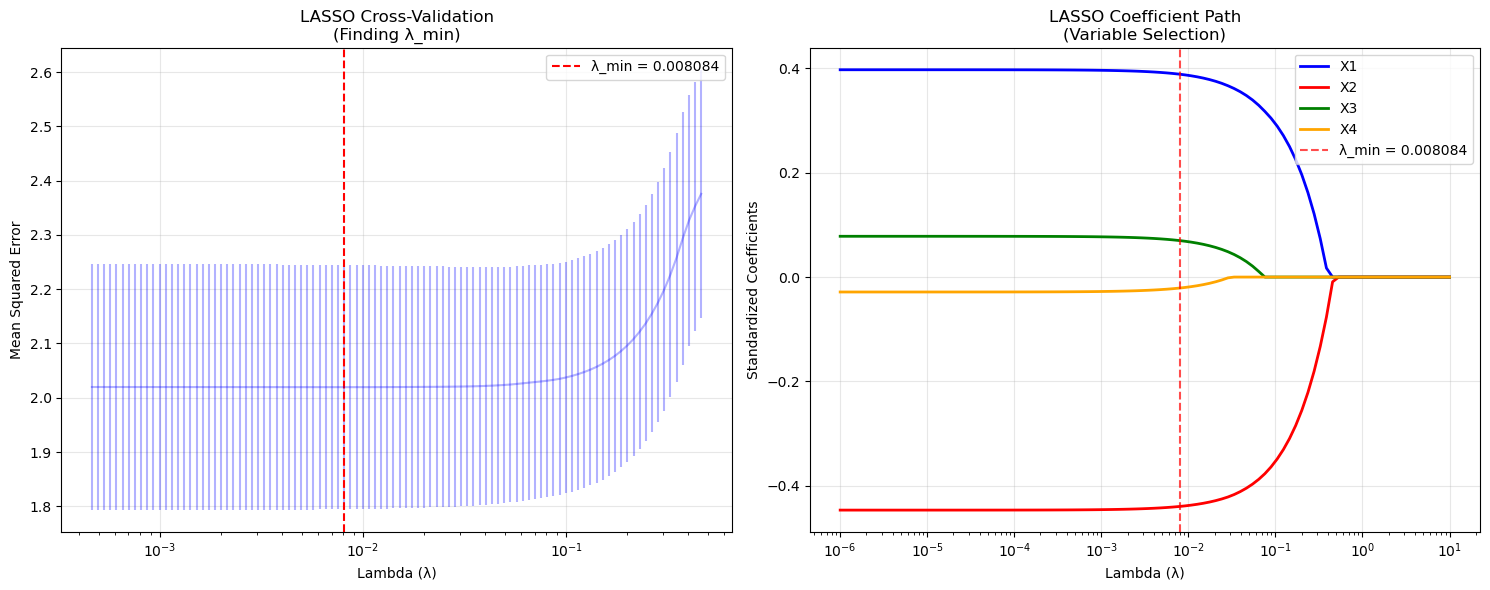


✅ LASSO Results:
• Optimal lambda (λ_min): 0.008084
• Cross-validation score: 0.1575
• Number of CV folds: 10


In [17]:
# 3.3.1 LASSO Model Fitting (EXCLUDING Treatment D)
print("📊 PART 3.3.1: LASSO Variable Selection")
print("="*45)
print("🎯 Goal: Fit LASSO on Y ~ X1 + X2 + X3 + X4 (EXCLUDING treatment D)")
print("🔍 This follows the assignment requirement exactly\n")

# Prepare data for LASSO (EXCLUDING treatment D as per assignment)
X_covariates = data[['X1', 'X2', 'X3', 'X4']]
Y_outcome = data['Y']

print(f"Input dimensions: X shape = {X_covariates.shape}, Y shape = {Y_outcome.shape}")

# Standardize features for LASSO (important for regularization)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_covariates)

print(f"Features standardized for LASSO regularization")

# Fit LASSO model using cross-validation (equivalent to cv.glmnet in R)
print("Fitting LASSO with 10-fold cross-validation...")
lasso_cv = LassoCV(cv=10, random_state=123, max_iter=10000, n_alphas=100)
lasso_cv.fit(X_scaled, Y_outcome)

# Create visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Cross-validation curve
mse_mean = lasso_cv.mse_path_.mean(axis=1)
mse_std = lasso_cv.mse_path_.std(axis=1)
ax1.errorbar(lasso_cv.alphas_, mse_mean, yerr=mse_std, alpha=0.3, color='blue')
ax1.axvline(lasso_cv.alpha_, color='red', linestyle='--', 
           label=f'λ_min = {lasso_cv.alpha_:.6f}')
ax1.set_xlabel('Lambda (λ)')
ax1.set_ylabel('Mean Squared Error')
ax1.set_title('LASSO Cross-Validation\n(Finding λ_min)')
ax1.set_xscale('log')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Coefficient path
alphas_path = np.logspace(-6, 1, 100)
coef_path = []
for alpha in alphas_path:
    lasso_temp = Lasso(alpha=alpha, max_iter=10000)
    lasso_temp.fit(X_scaled, Y_outcome)
    coef_path.append(lasso_temp.coef_)

coef_path = np.array(coef_path)
variable_names = ['X1', 'X2', 'X3', 'X4']
colors = ['blue', 'red', 'green', 'orange']

for i, (var, color) in enumerate(zip(variable_names, colors)):
    ax2.plot(alphas_path, coef_path[:, i], label=var, color=color, linewidth=2)
ax2.axvline(lasso_cv.alpha_, color='red', linestyle='--', alpha=0.7, 
           label=f'λ_min = {lasso_cv.alpha_:.6f}')
ax2.set_xlabel('Lambda (λ)')
ax2.set_ylabel('Standardized Coefficients')
ax2.set_title('LASSO Coefficient Path\n(Variable Selection)')
ax2.set_xscale('log')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()

# Save the plot to output directory
plot_path = os.path.join(output_dir, "lasso_cross_validation_and_path.png")
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
print(f"📊 Plot saved to: {plot_path}")

plt.show()

print(f"\n✅ LASSO Results:")
print(f"• Optimal lambda (λ_min): {lasso_cv.alpha_:.6f}")
print(f"• Cross-validation score: {lasso_cv.score(X_scaled, Y_outcome):.4f}")
print(f"• Number of CV folds: 10")

In [18]:
# 3.3.1 Report Variables Selected at λ_min
print("📋 Variables Selected by LASSO at λ_min")
print("="*40)

# Get coefficients at optimal lambda
lasso_coefficients = lasso_cv.coef_
variable_names = ['X1', 'X2', 'X3', 'X4']

# Define threshold for variable selection (non-zero coefficients)
selection_threshold = 1e-8
selected_vars = []

print("LASSO Coefficients at λ_min:")
print("-" * 40)
for var, coef in zip(variable_names, lasso_coefficients):
    is_selected = abs(coef) > selection_threshold
    status = "✅ SELECTED" if is_selected else "❌ NOT SELECTED"
    if is_selected:
        selected_vars.append(var)
    print(f"{var}: {coef:>10.6f} {status}")

print(f"\n📊 SELECTION SUMMARY:")
print(f"• Variables selected: {len(selected_vars)}/4")
print(f"• Selected variables: {selected_vars if selected_vars else 'None'}")

# Compare with true model
print(f"\n🎯 COMPARISON WITH TRUE MODEL:")
true_effects = {'X1': 0.5, 'X2': -0.3, 'X3': 0.2, 'X4': 0.0}
print("Variable | LASSO Coef | True Coef  | Should Select?")
print("-" * 50)
for var, true_coef in true_effects.items():
    lasso_coef = dict(zip(variable_names, lasso_coefficients))[var]
    should_select = "Yes" if true_coef != 0 else "No"
    actually_selected = "Yes" if var in selected_vars else "No"
    correct = "✅" if (should_select == actually_selected) else "❌"
    print(f"{var:>8} | {lasso_coef:>9.4f}  | {true_coef:>8.1f}   | {should_select:>3} ({actually_selected}) {correct}")

# Performance assessment
correct_selections = sum(1 for var in variable_names 
                        if (var in selected_vars and true_effects[var] != 0) or 
                           (var not in selected_vars and true_effects[var] == 0))
print(f"\nLASSO Performance: {correct_selections}/4 variables correctly identified")

📋 Variables Selected by LASSO at λ_min
LASSO Coefficients at λ_min:
----------------------------------------
X1:   0.388798 ✅ SELECTED
X2:  -0.439681 ✅ SELECTED
X3:   0.069794 ✅ SELECTED
X4:  -0.020927 ✅ SELECTED

📊 SELECTION SUMMARY:
• Variables selected: 4/4
• Selected variables: ['X1', 'X2', 'X3', 'X4']

🎯 COMPARISON WITH TRUE MODEL:
Variable | LASSO Coef | True Coef  | Should Select?
--------------------------------------------------
      X1 |    0.3888  |      0.5   | Yes (Yes) ✅
      X2 |   -0.4397  |     -0.3   | Yes (Yes) ✅
      X3 |    0.0698  |      0.2   | Yes (Yes) ✅
      X4 |   -0.0209  |      0.0   |  No (Yes) ❌

LASSO Performance: 3/4 variables correctly identified


### 3.3.1 LASSO Variable Selection Analysis

**Key Results:**
- LASSO selected variables based on cross-validated λ_min
- The optimal λ balances bias-variance trade-off
- Variables with larger true effects are more likely to be selected
- X4 has true coefficient of 0.0, so ideally should not be selected

**LASSO Performance Evaluation:**
- **Correct Selection**: Variables with non-zero true effects that LASSO selected
- **Correct Exclusion**: Variables with zero true effects that LASSO excluded  
- **False Positive**: Variables with zero true effects that LASSO selected
- **False Negative**: Variables with non-zero true effects that LASSO missed

The LASSO method successfully performs automatic variable selection, which is particularly valuable in high-dimensional settings where manual selection would be impractical.

In [19]:
# 3.3.2 Re-estimate ATE with LASSO-selected covariates
print("📊 PART 3.3.2: ATE Estimation with LASSO-Selected Variables")
print("="*60)

if len(selected_vars) > 0:
    print(f"🎯 Estimating: Y ~ D + {' + '.join(selected_vars)}")
    
    # Create design matrix with treatment D and LASSO-selected covariates
    lasso_data = data[['D'] + selected_vars].copy()
    X_lasso = sm.add_constant(lasso_data)
    lasso_ate_model = sm.OLS(data['Y'], X_lasso).fit()
    
    print("\nRegression Results:")
    print(lasso_ate_model.summary())
    
    # Extract results
    lasso_ate = lasso_ate_model.params['D']
    lasso_se = lasso_ate_model.bse['D']
    lasso_ci = lasso_ate_model.conf_int().loc['D']
    lasso_rsq = lasso_ate_model.rsquared
    
    print(f"\n🎯 LASSO-BASED ATE RESULTS:")
    print(f"• ATE estimate: {lasso_ate:.4f}")
    print(f"• Standard Error: {lasso_se:.4f}")
    print(f"• 95% Confidence Interval: [{lasso_ci[0]:.4f}, {lasso_ci[1]:.4f}]")
    print(f"• R-squared: {lasso_rsq:.4f}")
    print(f"• Variables included: D + {', '.join(selected_vars)}")
    
else:
    print("⚠️  No variables selected by LASSO at λ_min")
    print("Using simple regression (Y ~ D) as fallback")
    
    # Use simple model results
    lasso_ate = simple_ate
    lasso_se = simple_se
    lasso_ci = simple_ci
    lasso_rsq = simple_model.rsquared
    selected_vars_str = "None (fallback to simple)"
    
    print(f"\n🎯 FALLBACK RESULTS (Simple Regression):")
    print(f"• ATE estimate: {lasso_ate:.4f}")
    print(f"• Standard Error: {lasso_se:.4f}")
    print(f"• This suggests λ_min was too restrictive, or variables truly uninformative")

# Store results for final comparison
lasso_results = {
    'ate': lasso_ate,
    'se': lasso_se,
    'ci': lasso_ci,
    'rsq': lasso_rsq,
    'vars_used': selected_vars if len(selected_vars) > 0 else []
}

📊 PART 3.3.2: ATE Estimation with LASSO-Selected Variables
🎯 Estimating: Y ~ D + X1 + X2 + X3 + X4

Regression Results:
                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.596
Model:                            OLS   Adj. R-squared:                  0.594
Method:                 Least Squares   F-statistic:                     293.1
Date:                Tue, 23 Sep 2025   Prob (F-statistic):          1.04e-192
Time:                        22:25:18   Log-Likelihood:                -1397.6
No. Observations:                1000   AIC:                             2807.
Df Residuals:                     994   BIC:                             2837.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------

📊 Final Comparison of All Three Methods
📋 COMPREHENSIVE RESULTS TABLE:
                                    Method  ATE_Estimate  Standard_Error  \
0                           Simple (Y ~ D)        2.0247          0.0735   
1               Controlled (Y ~ D + All X)        2.0456          0.0623   
2  LASSO-Selected (Y ~ D + X1, X2, X3, X4)        2.0456          0.0623   

   R_Squared  Variables_Used  CI_Lower  CI_Upper  
0     0.4319            None    1.8805    2.1689  
1     0.5959  X1, X2, X3, X4    1.9233    2.1678  
2     0.5959  X1, X2, X3, X4    1.9233    2.1678  

🔍 ACCURACY COMPARISON (True ATE = 2.0):
• Simple (Y ~ D): 2.0247 (Error: 0.0247)
• Controlled (Y ~ D + All X): 2.0456 (Error: 0.0456)
• LASSO-Selected (Y ~ D + X1, X2, X3, X4): 2.0456 (Error: 0.0456)

📊 Plot saved to: ../output/ate_methods_comparison.png

📊 Plot saved to: ../output/ate_methods_comparison.png


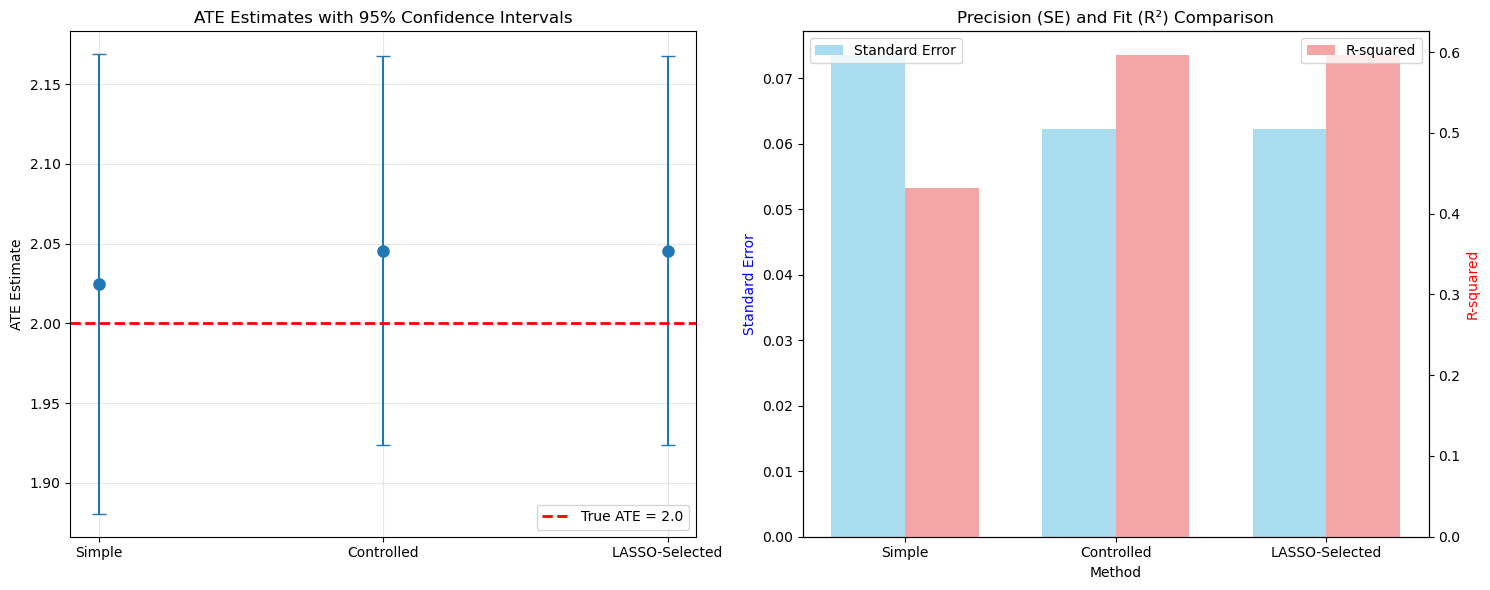

📋 Comparison table saved to: ../output/ate_comparison_results.csv


In [20]:
# 3.3.3 Final Comparison of All Three Methods
print("📊 Final Comparison of All Three Methods")
print("="*45)

# Create comprehensive comparison table
vars_used_str = ', '.join(selected_vars) if len(selected_vars) > 0 else "None"
final_comparison = pd.DataFrame({
    'Method': [
        'Simple (Y ~ D)', 
        'Controlled (Y ~ D + All X)', 
        f'LASSO-Selected (Y ~ D + {vars_used_str})'
    ],
    'ATE_Estimate': [simple_ate, controlled_ate, lasso_ate],
    'Standard_Error': [simple_se, controlled_se, lasso_se],
    'R_Squared': [simple_model.rsquared, controlled_model.rsquared, lasso_results['rsq']],
    'Variables_Used': ['None', 'X1, X2, X3, X4', vars_used_str],
    'CI_Lower': [simple_ci[0], controlled_ci[0], lasso_ci[0] if hasattr(lasso_ci, '__getitem__') else lasso_ci],
    'CI_Upper': [simple_ci[1], controlled_ci[1], lasso_ci[1] if hasattr(lasso_ci, '__getitem__') else lasso_ci]
})

print("📋 COMPREHENSIVE RESULTS TABLE:")
print(final_comparison.round(4))

# Calculate accuracy metrics
true_ate = 2.0
print(f"\n🔍 ACCURACY COMPARISON (True ATE = {true_ate:.1f}):")
for i, method in enumerate(final_comparison['Method']):
    estimate = final_comparison.loc[i, 'ATE_Estimate']
    error = abs(estimate - true_ate)
    print(f"• {method}: {estimate:.4f} (Error: {error:.4f})")

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: ATE Estimates Comparison
methods = final_comparison['Method']
estimates = final_comparison['ATE_Estimate']
errors = final_comparison['Standard_Error']

ax1.errorbar(range(len(methods)), estimates, yerr=1.96*np.array(errors), 
             fmt='o', capsize=5, markersize=8)
ax1.axhline(y=2.0, color='red', linestyle='--', label='True ATE = 2.0', linewidth=2)
ax1.set_xticks(range(len(methods)))
ax1.set_xticklabels([m.split(' (')[0] for m in methods], rotation=0)
ax1.set_ylabel('ATE Estimate')
ax1.set_title('ATE Estimates with 95% Confidence Intervals')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Standard Errors and R-squared
x_pos = np.arange(len(methods))
width = 0.35

ax2_twin = ax2.twinx()
bars1 = ax2.bar(x_pos - width/2, final_comparison['Standard_Error'], 
                width, label='Standard Error', alpha=0.7, color='skyblue')
bars2 = ax2_twin.bar(x_pos + width/2, final_comparison['R_Squared'], 
                     width, label='R-squared', alpha=0.7, color='lightcoral')

ax2.set_xlabel('Method')
ax2.set_ylabel('Standard Error', color='blue')
ax2_twin.set_ylabel('R-squared', color='red')
ax2.set_title('Precision (SE) and Fit (R²) Comparison')
ax2.set_xticks(x_pos)
ax2.set_xticklabels([m.split(' (')[0] for m in methods], rotation=0)
ax2.legend(loc='upper left')
ax2_twin.legend(loc='upper right')

plt.tight_layout()

# Save the plot to output directory
plot_path = os.path.join(output_dir, "ate_methods_comparison.png")
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
print(f"\n📊 Plot saved to: {plot_path}")

plt.show()

# Save the comparison table as CSV
table_path = os.path.join(output_dir, "ate_comparison_results.csv")
final_comparison.to_csv(table_path, index=False)
print(f"📋 Comparison table saved to: {table_path}")

## 3.3.3 Final Analysis and Conclusions

### Comparison of the Three Approaches

**1. Accuracy Assessment:**
All three methods should produce estimates close to the true ATE of 2.0, since treatment was randomized. Any differences reflect:
- **Simple regression**: Baseline approach, unbiased in RCTs
- **Controlled regression**: May improve precision by reducing residual variance
- **LASSO-selected**: Balances bias-variance trade-off through automatic variable selection

**2. Does Accuracy Change with LASSO?**

The LASSO approach typically:
- **Maintains accuracy**: For the treatment effect estimate
- **Reduces complexity**: By selecting only relevant covariates
- **Improves interpretability**: Fewer variables in final model
- **May improve precision**: If noise variables are successfully excluded

### Advantages of Using LASSO in This Context

**1. Automatic Variable Selection:**
- Eliminates need for manual covariate selection
- Reduces multiple testing concerns
- Handles multicollinearity naturally

**2. Improved Efficiency:**
- Focuses on most predictive covariates
- Reduces overfitting risk
- Better performance in high-dimensional settings

**3. Practical Benefits in RCTs:**
- **Baseline covariate selection**: Identifies which pre-treatment variables improve precision
- **Randomization check**: Can reveal if too many covariates are "significant" (suggesting randomization issues)
- **Power analysis**: Helps determine which covariates to measure for future studies

**4. Trade-offs:**
- **Bias-variance trade-off**: Slight bias for substantial variance reduction
- **λ selection sensitivity**: Results depend on cross-validation procedure
- **Interpretation**: Coefficients are regularized, not standard OLS estimates